In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/platesv2/sample_submission.csv
/kaggle/input/platesv2/plates.zip


### Loading data

In [8]:
import zipfile
with zipfile.ZipFile("/kaggle/input/platesv2/plates.zip", "r") as zip_ref:
    zip_ref.extractall("unizpped_plates")

In [79]:
from fastai.vision.all import *

path = Path("/kaggle/working/unizpped_plates/plates")
train_path = path/"train"
files = get_image_files(train_path)
print("Sample file:", files[0])
print("Type:", type(files[0]))
print("Full path:", str(files[0]))
print("Parent folder (label):", Path(files[0]).parent.name)

Sample file: /kaggle/working/unizpped_plates/plates/train/dirty/0001.jpg
Type: <class 'pathlib.PosixPath'>
Full path: /kaggle/working/unizpped_plates/plates/train/dirty/0001.jpg
Parent folder (label): dirty


Displaying one example from training sample

Label:  dirty


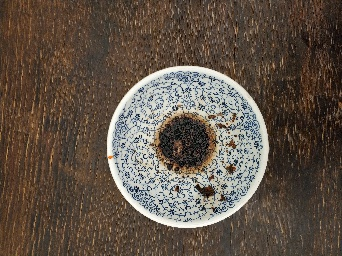

Image size:  (342, 256)


In [80]:
from PIL import Image
from IPython.display import display


img = Image.open(files[0])
print("Label: ",Path(files[0]).parent.name)
display(img)

print("Image size: ", img.size)

### Creation of Dataloader

Labels in Dataloader:  ['cleaned', 'dirty']


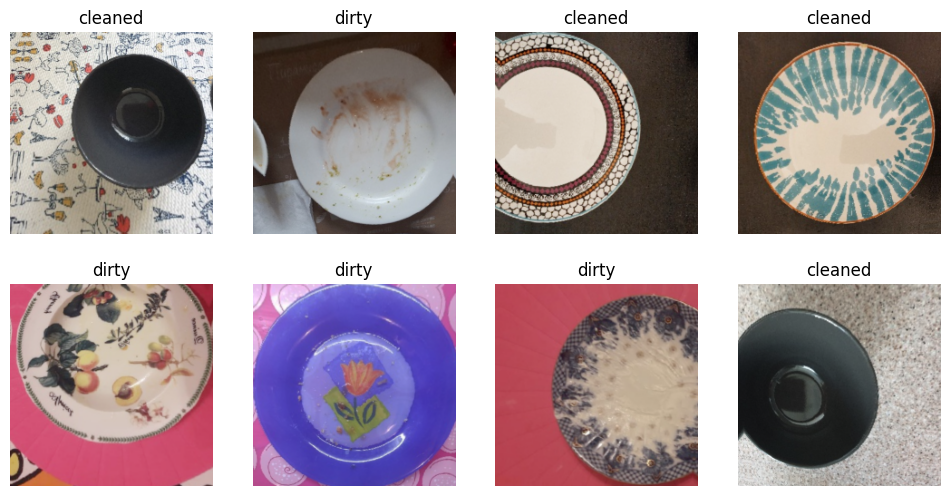

In [86]:
from fastai.data.all import *

def label_function(file):
    return Path(file).parent.name
    

datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    get_y=label_function,
    item_tfms=Resize(460),# Resize before augmenting
    batch_tfms=aug_transforms(size=224)
)

dls = datablock.dataloaders(train_path, bs=8)

print("Labels in Dataloader: ", dls.vocab)

dls.show_batch(unique=True)

### Finetunning model

In [87]:
learner = vision_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.245143,3.392248,0.625000,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.845894,1.365458,0.625000,00:06
1,0.917198,0.539845,0.250000,00:07
2,0.758507,0.320556,0.250000,00:06
3,0.597759,0.484434,0.125000,00:06
4,0.527230,0.935827,0.250000,00:07
5,0.476128,1.004056,0.250000,00:07
6,0.432042,0.945130,0.125000,00:06
7,0.373775,0.933582,0.125000,00:07
8,0.329354,0.950581,0.125000,00:07
9,0.346775,0.947653,0.125000,00:07


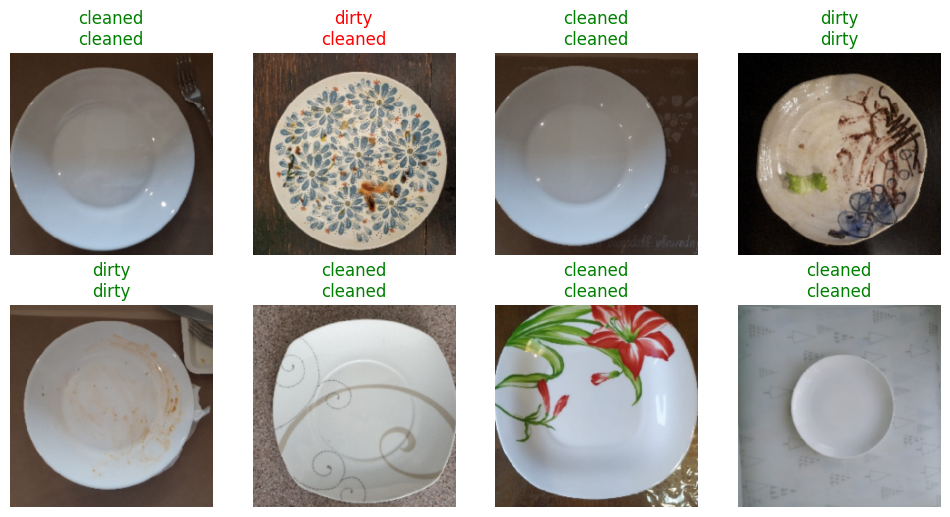

In [88]:
learner.show_results()

Load test results and make predicitons

Predicted label:  ('dirty', tensor(1), tensor([0.0083, 0.9917]))


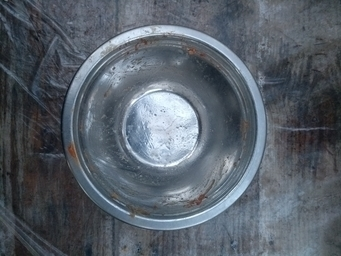

In [93]:
test_path = path/"test"
test_images = get_image_files(test_path)
img = Image.open(test_images[13])

print("Predicted label: ", learner.predict(test_images[13]))
display(img)

Creation of submission file

In [99]:
import pandas as pd

data = {
    "id": [],
    "label" : []
}

for image in test_images:
    id_= int(Path(image).stem)
    label = learner.predict(image)[0]
    data["id"].append(id_)
    data["label"].append(label)

submission_df = pd.DataFrame(data)
submission_df.head()


,id,label
0,389,dirty
1,578,dirty
2,161,dirty
3,437,dirty
4,152,cleaned


In [100]:
submission_df.to_csv("submission.csv", index=False)

Installing model weigths

In [101]:
learner.export("resnet18_plate_classification.pkl")